# Plots of modes

In [1]:
# %reset -f
import numpy as np

import matplotlib.pyplot as plt
import scipy
import scipy as sc
import scipy.stats as st
import scipy.special as spec
import scipy.constants as const
import matplotlib as mpl
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import scipy.integrate as integrate


import os
import pickle as pkl
import sys
sys.path.append('../PyRADISEgit')

# PySSD
import seaborn as sns
from PySSD.Distribution import Distribution,Gaussian
from PySSD.Detuning import LinearDetuning
# from PySSD.Dispersion import Dispersion
from PySSD.Integrator import Integrator #FixedTrapezoidalIntegrator, SimpsonIntegrator, TrapzIntegrator, DblquadIntegrator
# from PyRADISE.PySSDHelper  import get_tune_range, findQs
import PyRADISE.L2D2_functions as L2D2

# Plotting preparation
from plot_configuration import *
np.set_printoptions(precision=3,suppress=True) 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes,mark_inset
plt.close('all')

Finished configuring the plots.


In [2]:
pi2=np.pi*2
%matplotlib notebook
dir_save = '01_Output/'
pltdir = '03_Plots'

## Functions

In [3]:
def find_DiffusionSidebandWeight(sigma_x,maxOrder=50,tol=1e-3,debug=0):
    """
        Function to find the weight of the sideband 
        Taken as average bessel function squared over the longitudinal gaussian distribution
        NO LONGER RELEVANT WITH NEW THEORY
    """   
    factors = np.zeros(4)
    orders = np.arange(4)
    factors[0] = 1
    return factors,orders

     
    orders = np.arange(maxOrder+1)
    factors = np.zeros(maxOrder+1)
    if sigma_x>0:
        xs = np.linspace(0,6,50)*sigma_x
        phi_x = xs/sigma_x**2 * np.exp(-xs**2/sigma_x**2*.5)

        for m in orders:
            ys   = sc.special.jv(m,xs)
            mean = sc.integrate.simps(ys**2*phi_x,x=xs,even='first')
            factors[m]=mean
            if factors[m]/factors[0]< tol:
                factors = factors[:m+1]
                orders = orders[:m+1]
                if debug:
                    print('Need no more than %d sidebands: '%(m+1),factors)
                break
    else:
        factors = np.array([1])
        orders  = np.array([0])
    return factors,orders


# def calc_CapitalOmega(distribution,detuning,integrator_epsilon,Q0,modeDQ,tol=1e-4,flagFindalpha=[1,1],debug=0,maxJ=18):    
#     absModeDQ = np.abs(modeDQ) # Absolute value of undamped mode - used to find accuracy of mode
    
#     # Additional integrators
#     integrator1 = Integrator(distribution, detuning, maxJ=maxJ,epsilon=integrator_epsilon*1)
#     integrator2 = Integrator(distribution, detuning, maxJ=maxJ,epsilon=integrator_epsilon*2)
#     integrator4 = Integrator(distribution, detuning, maxJ=maxJ,epsilon=integrator_epsilon*4)
    
#     # Estimate of damped mode corresponding to free mode
#     dampDQ = modeDQ.real + 1j*integrator_epsilon
    
#     #debug
#     if debug:
#         dampDQs=[dampDQ]
#         modeDQs=[]
    
#     cnt = 0
#     err = 0
#     while True and absModeDQ>0:
#         if dampDQ.imag<=integrator_epsilon*1:
#             # Taylor approach to getting stabilized Omega
#             tempDQ = 2*integrator1.integrate(Q0+dampDQ.real) - 1*integrator2.integrate(Q0+dampDQ.real)+1j*(dampDQ.imag)
#             flag_taylor=True
#         else:
#             # Original approach to getting unstable Omega
# #             integrator1._detuning += 1j*(integrator_epsilon - dampDQ.imag)
# #             tempDQ=integrator1.integrate(Q0+dampDQ.real)
# #             integrator1._detuning -= 1j*(integrator_epsilon - dampDQ.imag)
#             tempDQ=integrator1.integrate(Q0+dampDQ.real + 1j*dampDQ.imag)
#             flag_taylor=False
        
#         # Calculate error
#         errold= err
#         err   = tempDQ-modeDQ

#         # Break if within tolerance
#         if np.abs(err)<absModeDQ*tol:
#             break

#         ## Update dampDQ (damped mode tune)
#         if cnt==0:
#             # Simple method
#             dDampDQ  =-(err*.5+errold*.05) 
#         else:
#             # Newton's method
#             dDampdMode = (dDampDQ)/(err-errold)
#             dDampDQ    = -err*dDampdMode 
#         dampDQ = dampDQ + dDampDQ
        
#         #debug
#         if debug or cnt>40 :
#             print("%2d:dampDQ=%11.4e + %11.4ei | err=%10.2e + %10.2ei - relerr=%.1e"%(
#                 cnt,dampDQ.real,dampDQ.imag,err.real,err.imag,np.abs(err)/absModeDQ))
#             if debug:
#                 modeDQs+=[tempDQ]
#                 dampDQs+=[dampDQ]
        
            
#         # Break if tried 50 times 
#         if cnt>50:
#             break
        
#         cnt+=1

#     # Calc alpha
#     alpha=1
#     if np.any(np.abs(flagFindalpha)>0) and flag_taylor:
#         # Calculate alpha 
#         alpha =  2j*integrator_epsilon/(
#                     integrator4.integrate(Q0+dampDQ.real)-integrator2.integrate(Q0+dampDQ.real))
#         # Use the parts of alpha as given by flagFindalpha
#         alpha = alpha.real*flagFindalpha[0] + 1j*alpha.imag*flagFindalpha[1]
#         dampDQold = dampDQ
#         dampDQ = dampDQ.real + 1j*alpha*dampDQ.imag
#         if debug:
#             print('Found alpha!=1, alpha=%.2e %s%.2ej |  dampDQ = %.2e %s%.3ej -> %.2e %s%.3ej'%(
#                         alpha.real,['+','-'][np.sign(alpha.imag)<0],np.abs(alpha.imag),
#                         dampDQold.real,['+','-'][np.sign(dampDQold.imag)<0],np.abs(dampDQold.imag),
#                         dampDQ.real,['+','-'][np.sign(dampDQ.imag)<0],np.abs(dampDQ.imag)))
        
        
#     if debug :
#         modeDQs = np.array(modeDQs)
#         dampDQs = np.array(dampDQs[:-1])
#         print('modeDQ',modeDQs)
#         print('dampDQ',dampDQs[1:])
#     return dampDQ , cnt , alpha, np.abs(err)/absModeDQ

# def latency_ana(dQ_coh,eta,dQ_ld,alpha,ax,bx,sigma_k,Trev = 1/11245.5):
#     BoBmA = bx/(bx-ax)
#     Jxmin = max(0,dQ_ld.real/ax)
#     Jxeff = Jxmin +BoBmA + BoBmA**2/(Jxmin+BoBmA)
#     dQ_sd = dQ_coh - 1j*dQ_ld.imag/alpha.real
    
#     L_L = (  Trev/2.5 * -(dQ_ld.imag)**5/(alpha.real*dQ_sd.imag *ax**2* abs(dQ_coh)**2)
#            *1/(Jxeff*sigma_k**2*eta**2)  )
    
# #     tempfunc = lambda x: x**4/(dQ_coh.imag*alpha.real-x)
# #     x0 = dQ_ld.imag
# #     Lquad = -integrate.quad(tempfunc,x0,0)[0] *5/x0**5 *dQ_sd.imag*alpha.real *L_L
    
#     tempfunc = lambda x: -5*x**4/(1+(1-x)*dQ_ld.imag/(dQ_sd.imag*alpha.real))
#     Lquad = integrate.quad(tempfunc,1,0)[0] *L_L
    
#     Lapprox = L_L*(1+np.imag(dQ_sd-dQ_coh)/(6*dQ_sd.imag)) 
#     return Lapprox,Lquad

In [4]:
# Test find_DiffusionSidebandWeight

Qs = 0.00191
sigma_dpp = 1e-4
Qp = 15
sigma_x  = Qp*sigma_dpp/Qs
f,s=find_DiffusionSidebandWeight(sigma_x,tol=1e-4,debug=0)
print(f,f[-3],f[0]/f[-3])

[1. 0. 0. 0.] 0.0 inf


/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


In [5]:


    
# Test find latency
energy = 6500*1000
gamma = energy/const.value("proton mass energy equivalent in MeV")
beta = np.sqrt(1-1/gamma**2)

emittnormx = 2e-6  ; Ioct = 280 #* 172/153
emittnormy = emittnormx
emittgeox = emittnormx/(beta*gamma)
emittgeoy = emittnormy/(beta*gamma)
beam_number = [1,2][0]
ax = [543.2,531.3][beam_number-1]*Ioct*emittgeox *6.5e6/energy
bx =-[383.6,383.4][beam_number-1]*Ioct*emittgeoy *6.5e6/energy


Qx = 0.31
frev = 11.2455e3
sigma_k = 1e-4/2

# Prepare PySSD
wmodeQ0x = Qx
integrator_epsilon = 2e-2 * ax *[1,4][bx==0]
flagFindalpha=[1,1]
detuning = LinearDetuning(Qx,ax,bx)
distribution = Gaussian()


# Values for latency calculation
BoBmA = bx/(bx-ax)
D0 = sigma_k**2*frev/2
Trev = 1/frev

ETA = 0.04
dQ_coh = -8.5e-5 + 4e-6j*1
dQ_coh*=1.0e-2

# calculate damped mode
dQ_ld,cnt,alpha,relerr=calc_CapitalOmega(distribution,detuning,integrator_epsilon,
                                          Qx,dQ_coh,tol=1e-4,flagFindalpha=[1,1],debug=0,maxJ=2)

# calculate latency

Jxmin = max(0,dQ_ld.real/ax)
Jxeff = Jxmin +BoBmA + BoBmA**2/(Jxmin+BoBmA)
dQ_sd = dQ_coh - 1j*dQ_ld.imag/alpha.real
L_L = (  Trev/2.5 * -(dQ_ld.imag)**5/(alpha.real*dQ_sd.imag *ax**2* abs(dQ_coh)**2)
       *1/(Jxeff*sigma_k**2*ETA**2)  )
L_approx = L_L*(1+np.imag(dQ_sd-dQ_coh)/(6*dQ_sd.imag)) 

L_L2 = Trev/2.5 *( np.imag(dQ_sd-dQ_coh)**5/(dQ_sd.imag *ax**2* abs(dQ_coh)**2)
             *alpha.real**4/(Jxeff*sigma_k**2*ETA**2)  )

print('Latency = %.2f min = %.5e s'%(L_approx/60,L_approx),L_L,L_L2)
print('ax=%.3e, bx=%.3e , bx/ax=%.5f'%(ax,bx,bx/ax))
print('sigma_dpp=%.3e'%sigma_dpp)
print('dQ_coh = %.3e+%.3ei'%(dQ_coh.real,dQ_coh.imag))
print('dQ_ld = %.3e+%.3ei'%(dQ_ld.real,dQ_ld.imag))
print('dQ_sd = %.3e+%.3ei'%(dQ_sd.real,dQ_sd.imag))
print('alpha',alpha.real)

La2,Lq2= latency_ana(dQ_coh,ETA,dQ_ld,alpha,ax,bx,sigma_k)
print('Latency = %.5e min = %.5e s ≈ %.5e min = %.5e s'%(Lq2/60,Lq2,La2/60,La2))


tempfunc = lambda x: x**4/(dQ_coh.imag*alpha.real-x)
x0 = dQ_ld.imag
Lquad1 = -integrate.quad(tempfunc,x0,0)[0] *5/x0**5 *dQ_sd.imag*alpha.real *L_L

tempfunc = lambda x: -5*x**4/(1+(1-x)*dQ_ld.imag/(dQ_sd.imag*alpha.real))
tempfunc = lambda x: -5*x**4/(1-(1-x)*(dQ_sd.imag-dQ_coh.imag)/(dQ_sd.imag))
Lquad2 = integrate.quad(tempfunc,1,0)[0] *L_L
print(Lquad1/60,Lquad2/60,Lquad2/L_L)

/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:24: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


NameError: name 'calc_CapitalOmega' is not defined

# BimBim

## Load file

In [3]:
# BimBim input values
# /afs/cern.ch/work/x/xbuffat/public/LHCDipoleMoment/LHCDipoleMoment_HTC.sh

# intensity = 1E11
# nDim = 2
# energy = 6.5E3
# emittance = 2E-6
# sigs = 1.05E-9/4.0*cst.c
# momentumCompaction = 3.483575072011584e-04
# gamma = energy*1E3/cst.value('proton mass energy equivalent in MeV')
# beta=np.sqrt(1.-1./(gamma**2))
# eta = momentumCompaction-1.0/gamma**2
# voltage = 12.0E6
# h = 35640
# p0=cst.m_p*beta*gamma*cst.c
# qs=np.sqrt(cst.e*voltage*eta*h/(2*np.pi*beta*cst.c*p0))
# averageRadius = 26658.883199999/(2*np.pi)
# sigp = qs*sigs/(averageRadius*eta)
# qbeta = 0.31
# outputFileName = os.path.join(outputDir,studyName+'.pkl')
# wakeDefinition = WakeFromTable('/afs/cern.ch/work/x/xbuffat/BimBim_workspace/wakes/wakeforhdtl_PyZbase_Allthemachine_6p5TeV_B1_LHC_ft_6.5TeV_B1_2017_WF.dat')

# fill1 = '1 1 1 0'
# fill2 = '1 0 1 0'


# BimBim HL

# intensity = 2.3E11
# nDim = 2
# energy = 7E3
# emittance = 2E-6
# sigs = 1.2E-9/4.0*cst.c
# momentumCompaction = 3.483575072011584e-04
# gamma = energy*1E3/cst.value('proton mass energy equivalent in MeV')
# beta=np.sqrt(1.-1./(gamma**2))
# eta = momentumCompaction-1.0/gamma**2
# voltage = 16.0E6
# h = 35640
# p0=cst.m_p*beta*gamma*cst.c
# qs=np.sqrt(cst.e*voltage*eta*h/(2*np.pi*beta*cst.c*p0))
# averageRadius = 26658.883199999/(2*np.pi)
# sigp = qs*sigs/(averageRadius*eta)
# qbeta = 0.31



In [4]:

nSlice = 80
nRing = 40

outputDir = dir_save+'/LHCDipoleMoments/'
outputDir = dir_save+'/fromXB/'
flag_HL = 0
if flag_HL:
    studyName = 'DipoleMoment_HL40cm_noCC_nSlice80_nRing40'
    studyName = 'DipoleMoment_HL40cm_nSlice80_nRing40'
else:
    studyName = "LHCDipoleMoment_idealADT_B1_nSlice80_nRing40"
#     studyName = 'LHCDipoleMoment_LatencyMDB2H_nSlice80_nRing40'
    # studyName = "LHCDipoleMoment_realADT_B1_nSlice80_nRing40"
    ### studyName = 'LHCDipoleMoment_nSlice'+str(nSlice)+'_nRing'+str(nRing)


outputFileName = os.path.join(outputDir,studyName+'.pkl')
if not os.path.exists(outputFileName):
    print(outputFileName,'does not exist')


myFile = open(outputFileName,'rb')
if flag_HL:
    [dGains,chromas,coherentTuneShifts,sideBands,dipoleMoments,energy,Qx,Qs] = pkl.load(myFile)
else:
    [dGains,chromas,coherentTuneShifts,sideBands,dipoleMoments] = pkl.load(myFile)

myFile.close()

print('dGains [1e-3]',dGains*1e3)
print('chroma',chromas)

X,Y = np.meshgrid(chromas,dGains)
maxDipoleMoments = np.zeros_like(X,dtype=float)
maxImags = np.zeros_like(X,dtype=float)
maxReals = np.zeros_like(X,dtype=float)
maxSideBand = np.zeros_like(X,dtype=float)

for iGain in range(np.shape(dGains)[0]):
    for iChroma in range(np.shape(chromas)[0]):
        maskSB = np.abs(sideBands[iGain,iChroma,:])>=0
        maskIMQ= np.imag(coherentTuneShifts[iGain,iChroma,:])>0
        mask = ((1*maskSB)*(1*maskIMQ))>0

        
        if np.max(mask)>0:
#             print(dGains[iGain],chromas[iChroma],np.sum(mask))
#             mask = np.logical_and(np.imag(coherentTuneShifts[iGain,iChroma,:])>0,np.abs(sideBands[iGain,iChroma,:])<nSlice/4)
            tmpCoherentTuneShifts = coherentTuneShifts[iGain,iChroma,mask]
            tmpSideBands = sideBands[iGain,iChroma,mask]
            tmpDipoleMoments = dipoleMoments[iGain,iChroma,mask]
            
            iMax = np.argmax(np.abs(tmpCoherentTuneShifts)*np.imag(tmpCoherentTuneShifts)*tmpDipoleMoments)
#             iMax = np.argmax(np.abs(tmpCoherentTuneShifts))
#             print(dGains[iGain],chromas[iChroma],np.sum(mask),iMax)
            
            maxImags[iGain,iChroma] = np.imag(tmpCoherentTuneShifts[iMax])
            maxReals[iGain,iChroma] = np.real(tmpCoherentTuneShifts[iMax])
            maxDipoleMoments[iGain,iChroma] = tmpDipoleMoments[iMax]
            maxSideBand[iGain,iChroma] = tmpSideBands[iMax]

            #if iChroma == 0:
            #    print(dGains[iGain],tmpCoherentTuneShifts)
        else:
            maxImags[iGain,iChroma] = np.nan
            maxReals[iGain,iChroma] = np.nan
            maxDipoleMoments[iGain,iChroma] = np.nan
            maxSideBand[iGain,iChroma] = np.nan

  

dGains [1e-3] [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40. ]
chroma [-20. -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.
  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.   6.   7.
   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.]


## Analytical latency gain,chroma scan

In [5]:
gamma65=6.5e6/const.value("proton mass energy equivalent in MeV")
beta65 = np.sqrt(1-1/gamma65**2)
emittgeo65 = 2e-6/(beta65*gamma65)

if flag_HL :
    energy = 7000*1000
    emittnormx = 1.7e-6
    Ioct = 550
    intensity = 2.3e11
    intensity_BB = 2.3e11
    dQ_imag_scale = 1
    
    bunchlength=1.2
    bunchlength_BB=1.2
    voltage = 16.0E6
    momentumCompaction = 3.483575072011584e-04
    
    JMaxSD =  4.5
    
    
else:
    energy = 6500*1000
    emittnormx = 2e-6 #*.85
    Ioct = 280 

    intensity = 1.1e11
    intensity_BB = 1.0e11
    dQ_imag_scale = 1
    
    bunchlength = 1.05
    bunchlength_BB = 1.1
    voltage = 12.0E6
    momentumCompaction = 3.483575072011584e-04

    JMaxSD=18


emittnormy = emittnormx
gamma = energy/const.value("proton mass energy equivalent in MeV")
beta = np.sqrt(1-1/gamma**2)
h=35640
eta = momentumCompaction-1.0/gamma**2
p0=const.m_p*beta*gamma*const.c
Qs=np.sqrt(const.e*voltage*eta*h/(2*np.pi*beta*const.c*p0))
averageRadius = 26658.883199999/(2*np.pi)

sigs = bunchlength_BB*1E-9/4.0*const.c
sigp = Qs*sigs/(averageRadius*eta)


emittgeox = emittnormx/(beta*gamma)
emittgeoy = emittnormy/(beta*gamma)
sigma_dpp = sigp * bunchlength/bunchlength_BB


Qx = 0.31
frev = 11.2455e3
sigma_k = 1e-4 * np.sqrt(2e-6/emittnormx)
sigma_k = 1e-4 * np.sqrt(1.9e-6/emittnormx) * 0.5648

# Detuning coefficients
    #543.2/-383.6 for B1
    #531.3/-383.4 for B2
beam_number = [1,2][0]
ax = [543.2,531.3][beam_number-1]*Ioct*emittgeox *6.5e6/energy
bx =-[383.6,383.4][beam_number-1]*Ioct*emittgeoy *6.5e6/energy

print('ax=%.3e, bx=%.3e , bx/ax=%.5f'%(ax,bx,bx/ax))
print('sigma_dpp=%.3e'%sigma_dpp)
print('Qs = %.3e'%Qs)
print('noise=%.2e'%sigma_k)

# Prepare PySSD
wmodeQ0x = Qx
integrator_epsilon = 2e-2 * ax *[1,4][bx==0]
flagFindalpha=[1,1]
detuning = LinearDetuning(Qx,ax,bx)
distribution = Gaussian()


# Values for latency calculation
BoBmA = bx/(bx-ax)
D0 = sigma_k**2*frev/2
Trev = 1/frev



#######################################
# Choose what chromas and gains to calculate latency for
chromas_loc = np.arange(0,20.1,1)
gains_loc=np.arange(0,0.02001,0.0005*1)
# chromas_loc = np.arange(5,15.1,10)
# gains_loc=np.arange(0.01,0.0116,0.0005*10)/2
# chromas_loc = chromas ; gains_loc=dGains

nChroma = np.size(chromas_loc)
nGains = np.size(gains_loc)
print('nChroma=%.0f, nGains=%.0f'%(nChroma,nGains))

ax=4.391e-05, bx=-3.101e-05 , bx/ax=-0.70619
sigma_dpp=1.017e-04
Qs = 1.910e-03
noise=5.50e-05
nChroma=21, nGains=41


/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:75: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


In [86]:
# Tolerances at different steps
tol0=0.05

for iii in range(3):
    intensity_i = intensity*[1.,1.3,1.2][iii]
    if iii>0: continue
    
    # Arrays to store results
    Lat1 = np.zeros((nChroma,nGains))+np.nan
    Lat2 = np.zeros((nChroma,nGains))+np.nan
    dQ1 = np.zeros((nChroma,nGains),dtype=np.complex)+np.nan
    dQ2 = np.zeros((nChroma,nGains),dtype=np.complex) +np.nan
    Margin1 = np.zeros((nChroma,nGains))+np.nan
    for iChroma_loc,chroma in enumerate(chromas_loc):
        iChroma = np.argmin(np.abs(chroma-chromas))
    #     if chroma<0 or chroma%3>0:continue
        sigma_x = chroma*sigma_dpp/Qs
        nSB = 20 
        factorQs = 1
        print("Q'",chroma,iChroma_loc,iChroma,chromas[iChroma],nSB,factorQs )
        for iGain_loc,gain in enumerate(gains_loc):
            iGain = np.argmin(np.abs(gain-dGains))
    #         if iGain%10>0: continue
    #         print('g',gain,iGain_loc,iGain,dGains[iGain])

            maskSB = np.abs(sideBands[iGain,iChroma,:])<=nSB
            maskIMQ= np.imag(coherentTuneShifts[iGain,iChroma,:])>0
            mask = ((1*maskSB)*(1*maskIMQ))>0

            if np.max(mask)>0:
                tmpDQ = coherentTuneShifts[iGain,iChroma,mask]
                tmpSB = np.int32(sideBands[iGain,iChroma,mask])
                tmpETA = dipoleMoments[iGain,iChroma,mask]

                # First estimate (not right scaling, but gives approximate order)
                L0inv = np.abs(tmpDQ)*np.imag(tmpDQ)*tmpETA*factorQs

                # Continue with all values within a factor tol0 from L0
                mask  = (L0inv>tol0*np.max(L0inv))
                if np.sum(mask*1)<2 and np.size(L0inv)>2:
                    threshold = np.sort(L0inv)[-3]
                    mask = L0inv>=threshold
                elif np.sum(mask*1)>10 :
                    threshold = np.sort(L0inv)[-10]
                    mask = L0inv>=threshold


                tmpDQ = tmpDQ[mask]
                tmpSB = tmpSB[mask]
                tmpETA= tmpETA[mask]
                L0inv = L0inv[mask]

                # For each of the modes found, calculate the theoretical latency
                nmodes = np.size(tmpDQ)
                locLat = np.zeros(nmodes)
                locDQld= np.zeros(nmodes,dtype= np.complex128)
                for i in range(nmodes):
                    dQ_coh = tmpDQ[i] * intensity_i/intensity_BB
                    dQ_coh = dQ_coh.real + 1j*dQ_coh.imag*dQ_imag_scale
                    
                    SB = tmpSB[i]
                    ETA = tmpETA[i]

                    # calculate damped mode
                    dQ_ld,cnt,alpha,relerr,dQ_free,dQ_sd= L2D2.calc_CapitalOmega(
                                            distribution,detuning,integrator_epsilon,
                                            Qx,dQ_coh,tol=1e-4,flagFindalpha=[1,1],debug=-1,JMaxSD=JMaxSD)
#                     dQ_ld,cnt,alpha,relerr=calc_CapitalOmega(distribution,detuning,integrator_epsilon,
#                                                               Qx,dQ_coh,tol=1e-4,flagFindalpha=[1,1],debug=0)
    #                 dQ_ld,alpha,cnt,relerr=calc_CapitalOmega(distribution,detuning,integrator_epsilon,
    #                                                           Qx,dQ_coh,tol=1e-4,flagFindalpha=[1,1],debug=0)


                    # calculate latency
                    L_approx,Lquad= L2D2.latency_ana(dQ_coh,ETA,dQ_ld,alpha,ax,bx,sigma_k)
#                     Jxmin = max(0,dQ_ld.real/ax)
#                     Jxeff = Jxmin +BoBmA + BoBmA**2/(Jxmin+BoBmA)
#                     dQ_sd = dQ_coh - 1j*dQ_ld.imag/alpha.real
#                     L_L = (  Trev/2.5 * -(dQ_ld.imag)**5/(alpha.real*dQ_sd.imag *ax**2* abs(dQ_coh)**2)
#                            *1/(Jxeff*sigma_k**2*ETA**2*factorQs)  )
#                     L_approx = L_L*(1+np.imag(dQ_sd-dQ_coh)/(6*dQ_sd.imag)) 
                    
                    #Store values
                    locDQld[i] = dQ_ld
                    locLat[i] = max(0,Lquad)  #Negative latency means that it is already unstable

                print(iChroma_loc,iGain_loc,'g=%.4f'%gain,'Ll',nmodes,locLat/np.min(locLat),tmpSB,tmpETA,locDQld.imag*1e6)
                mask = np.argsort(locLat)[:2]
                Lat1[iChroma_loc,iGain_loc] = locLat[mask[0]]
                dQ1[iChroma_loc,iGain_loc]  = tmpDQ[mask[0]]
                if np.size(mask)>1:
                    Lat2[iChroma_loc,iGain_loc] = locLat[mask[1]]
                    dQ2[iChroma_loc,iGain_loc] = tmpDQ[mask[1]]
                    
                # Find octupole margin
                if 1:
                    dQ_coh = tmpDQ[mask[0]] * intensity_i/intensity_BB
                    dQ_coh = dQ_coh.real + 1j*dQ_coh.imag*dQ_imag_scale
                    
                    axt,dQ_,al_,cnt_=L2D2.find_axThreshold(dQ_coh,Qx,bafac=bx/ax,distribution=Gaussian(),
                                                           JMaxSD=JMaxSD,method=2)
                    Margin1[iChroma_loc,iGain_loc] = ax/axt
                    print('mode %.3e+%.3e -> %.3e+%.3e -- a margin =%.2f'%(
                            tmpDQ[mask[0]].real,tmpDQ[mask[0]].imag,dQ_.real,dQ_.imag,ax/axt))


    with open(dir_save+'/NEW4_%s_scan_%dQp%.0fto%.0f_%dg_emIoct%.0f_N%.1fe10.pkl'%(studyName,
            nChroma,chromas_loc[0],chromas_loc[-1],nGains,emittnormx*1e6*Ioct,intensity_i*1e-10),'wb') as pklfile:
        pkl.dump([chromas_loc,gains_loc,Lat1,Lat2,dQ1,dQ2,Margin1],pklfile)

Q' 5.0 0 25 5.0 20 1
0 0 g=0.0050 Ll 3 [  1.     72.158 106.12 ] [-2 -2  2] [0.028 0.019 0.003] [-13.106 -22.68  -14.223]
mode -6.362e-05+1.930e-06 -> -5.721e-05+2.122e-09 -- a margin =2.02
Q' 15.0 1 35 15.0 20 1
1 0 g=0.0050 Ll 4 [   1.    1963.945 4711.553 9803.359] [ 0 -3  0  3] [0.04  0.023 0.023 0.013] [ -6.024 -19.123 -21.903 -20.17 ]
mode -8.501e-05+3.954e-06 -> -7.547e-05+1.504e-09 -- a margin =1.35


In [6]:
# intensity=1.1e11*1.3
flag_all=0
flag_5and15=1

if 1:
    filename = '/NEW4_%s_scan_%dQp%.0fto%.0f_%dg_emIoct%.0f_N%.1fe10.pkl'%(studyName,
        nChroma,chromas_loc[0],chromas_loc[-1],nGains,emittnormx*1e6*Ioct,intensity*1e-10 )
    print(filename)
    with open(dir_save+filename,'rb') as pklfile:
#         [chromas_loc,gains_loc,Lat1,Lat2,dQ1,dQ2] = pkl.load(pklfile)
        [chromas_loc,gains_loc,Lat1,Lat2,dQ1,dQ2,Margin1] = pkl.load(pklfile)
    

if flag_all:
    print(gains_loc*1e3,chromas_loc)
    print(dQ1)
    print(np.shape(Lat1))
    print(Lat1/60)
    print(alpha)
    
if flag_5and15:
    gainOP= 0.005 *1
    indg= np.argmin(np.abs(gains_loc-gainOP))
    indQp=np.argmin(np.abs(chromas_loc-15))
    lat15 = Lat1[indQp,indg]/60
    margin15 = Margin1[indQp,indg]

    indg= np.argmin(np.abs(gains_loc-gainOP))
    indQp=np.argmin(np.abs(chromas_loc-5))
    lat5 = Lat1[indQp,indg]/60
    margin5 = Margin1[indQp,indg]
    print(lat5,lat15,lat5/lat15)
    print(studyName,"Q'=5, L=%.1fe min | Q'=15, L=%.1f min"%(lat5,lat15))
    print("Margin(5) = %.4f , Margin(15) = %.4f"%(margin5, margin15))
    
    

/NEW4_LHCDipoleMoment_idealADT_B1_nSlice80_nRing40_scan_21Qp0to20_41g_emIoct560_N11.0e10.pkl
2159.082949366254 67.96170770877973 31.769109725995452
LHCDipoleMoment_idealADT_B1_nSlice80_nRing40 Q'=5, L=2159.1e min | Q'=15, L=68.0 min
Margin(5) = 2.4975 , Margin(15) = 1.6724


LHCDipoleMoment_idealADT_B1_nSlice80_nRing40 Q'=5, L=829.9e min | Q'=15, L=12.1 min
/NEW4_LHCDipoleMoment_idealADT_B1_nSlice80_nRing40_scan_21Qp0to20_41g_emIoct560_N11.0e10.pkl
2159.082949366254 67.96170770877973 31.769109725995452
/NEW4_LHCDipoleMoment_idealADT_B1_nSlice80_nRing40_scan_2Qp5to15_1g_emIoct560_N11.0e10.pkl # wrong nameing
1145.7865157582453 22.18784683951645 51.64027514907868

LHCDipoleMoment_idealADT_B1_nSlice80_nRing40 Q'=5, L=2159.1e min | Q'=15, L=68.0 min DipoleMoment_HL40cm_noCC_nSlice80_nRing40    Q'=5, L=6627.7e min | Q'=15, L=1898.7 min
DipoleMoment_HL40cm_nSlice80_nRing40         Q'=5, L=6382.9e min | Q'=15, L=1794.2 min , margin=2.32
DipoleMoment_HL40cm_nSlice80_nRing40 Q'=5, L=5589.8e s | Q'=15, L=1445.8 s, octupole margin = 2.17


Correct dQ_sd
/NEW3_LHCDipoleMoment_idealADT_B1_nSlice80_nRing40_scan_2Qp5to15_1g_emIoct560_N11.0e10.pkl
2046.2151488652603 65.65142269529458 31.16787214745185
/NEW3_LHCDipoleMoment_idealADT_B1_nSlice80_nRing40_scan_2Qp5to15_1g_emIoct560_N13.0e10.pkl
641.9625546441372 7.845014446317858 81.83064021576776
/NEW3_LHCDipoleMoment_idealADT_B1_nSlice80_nRing40_scan_2Qp5to15_1g_emIoct560_N13.2e10.pkl
569.9179160110186 6.1675467927980065 92.40593304886241
/NEW3_LHCDipoleMoment_idealADT_B1_nSlice80_nRing40_scan_2Qp5to15_1g_emIoct560_N14e10.pkl
292.4482287208739 1.4254943324887341 205.15565867617025

Wrong dQ_sd
/NEW3_LHCDipoleMoment_idealADT_B1_nSlice80_nRing40_scan_2Qp5to15_1g_emIoct560_N10e10.pkl
3556.820286470141 177.00459878100853 20.09450777530739
/NEW3_LHCDipoleMoment_idealADT_B1_nSlice80_nRing40_scan_2Qp5to15_1g_emIoct560_N11e10.pkl
2080.610727887513 71.02549451503945 29.293857678765605
/NEW3_LHCDipoleMoment_idealADT_B1_nSlice80_nRing40_scan_2Qp5to15_1g_emIoct560_N12e10.pkl
1199.5192982789333 26.217429741603585 45.75274197742791
/NEW3_LHCDipoleMoment_idealADT_B1_nSlice80_nRing40_scan_2Qp5to15_1g_emIoct560_N14e10.pkl
317.76245101714005 1.5553286699038251 204.30566038288816
/NEW3_LHCDipoleMoment_idealADT_B1_nSlice80_nRing40_scan_2Qp5to15_1g_emIoct431_N11e10.pkl
317.7624510168873 1.555328669904145 204.30566038268364
/NEW3_LHCDipoleMoment_idealADT_B1_nSlice80_nRing40_scan_2Qp5to15_1g_emIoct560_N13e10.pkl
681.6378266351805 8.611676965083701 79.15273986691574

-2 5


<IPython.core.display.Javascript object>


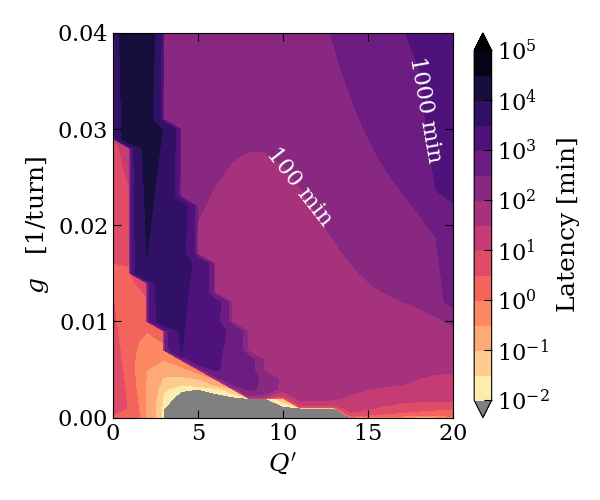

[  0.    130.363  11.731   0.364   0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.001   0.113  39.962] (21, 41)


In [13]:
# from matplotlib import ticker, cm
# posTicks = np.logspace(np.log10(vlmax),np.log10(vlmax)+nDec,1+nDec)
#             cticks = np.concatenate((-posTicks,[0],posTicks))


X,Y = np.meshgrid(chromas_loc,gains_loc*2)
tunit = 1
tscale = [1,60,3600][tunit]
tlabel = ['s','min','h'][tunit]
xlim = [0,20]
ylim = [0,0.04]
# xlim = [-20,20] ; ylim =[0,0.08]

cmap0 = cm.get_cmap(['plasma_r','inferno_r','hot_r','magma_r'][3])
cmap0.set_over('k')
cmap0.set_under('grey')

if 1 :
    Lat1[Lat1==0] = 1e-9

# latency #1
Zmin = max(0.1-2*tunit,np.log10(np.nanmin(Lat1/tscale))-1)
Zmax = min(5.9-2*tunit,np.log10(np.nanmax(Lat1/tscale))+1)
Zmin,Zmax = -2,5
lev_exp = np.arange(np.floor(Zmin),np.ceil(Zmax)+0.1,1/2)
print(Zmin,Zmax)
levs = np.power(10, lev_exp)

plt.figure()
ax=plt.gca()


# CS2 = plt.contour(X,Y,Lat1.T/tscale,cmap =cmap0, norm=mpl.colors.LogNorm(),levels = np.logspace(-1,3,5))
im=plt.contourf(X,Y,Lat1.T/tscale,levs, norm=mpl.colors.LogNorm(),cmap=cmap0,extend='both')
# for LEV in np.logspace(0,6,7):
#     ax.clabel(im, [LEV],inline=True,inline_spacing=0,fmt='%.0f',
#                      colors='w',fontsize=16,
# #                       manual=True
#                      )

if flag_HL:
    plt.text(11,0.012,'1000 min',color='w',ha='center',va='center',rotation=-55)
    plt.text(17,0.034,r'10$\,$000 min',color='w',ha='center',va='center',rotation=-55)
else:
    plt.text(11,0.024,'100 min',color='w',ha='center',va='center',rotation=-52)
    plt.text(18.4,0.032,'1000 min',color='w',ha='center',va='center',rotation=-80)


cb=plt.colorbar(label='Latency [$\mathrm{%s}$]'%tlabel)
cb.set_ticks(10**np.arange(np.floor(Zmin),np.ceil(Zmax)+0.1,1))
# for c in im.collections:
#     c.set_edgecolor("face")
#     c.set_linewidth(0.000000000001)

plt.yticks(np.arange(10)*0.01)
plt.xlim(xlim) ; plt.ylim(ylim)
plt.xlabel(r'$Q^\prime$')
plt.ylabel(r'$g$   [1/turn]')
plt.tight_layout()

plt.savefig(pltdir+'/%s_scan_%dQp%dto%d_%dg_tunit%s_emIoct%.0f.eps'%(
        studyName,np.size(chromas_loc),xlim[0],xlim[1],np.size(gains_loc),tlabel,emittnormx*1e6*Ioct))

print(Lat1[:,0],Lat1.shape)


0 4


<IPython.core.display.Javascript object>


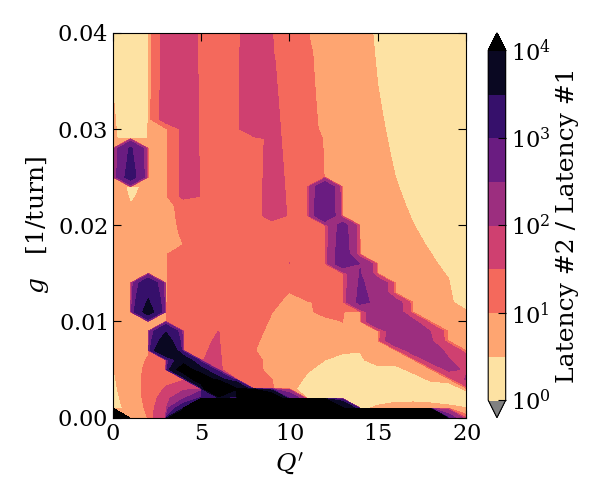

<IPython.core.display.Javascript object>


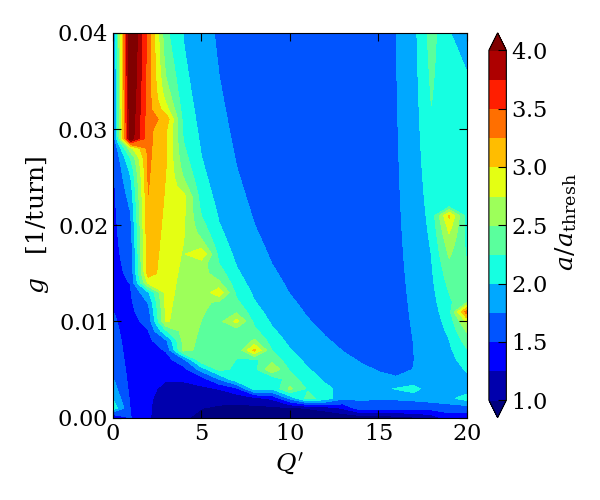

In [9]:



# How problematic is mode nr 2
Zmin = 0
Zmax = 4
lev_exp = np.arange(np.floor(Zmin),np.ceil(Zmax)+0.1,1/2)
print(Zmin,Zmax)
levs = np.power(10, lev_exp)

plt.figure()
im=plt.contourf(X,Y,(Lat2/Lat1).T,levs, norm=mpl.colors.LogNorm(),cmap=cmap0,extend='both')
cb = plt.colorbar(label='Latency #2 / Latency #1')
cb.set_ticks(10**np.arange(np.floor(Zmin),np.ceil(Zmax)+0.1,1))
# for c in im.collections:
#     c.set_edgecolor("face")
#     c.set_linewidth(0.000000000001)

plt.yticks(np.arange(10)*0.01)
plt.xlim(xlim)  ; plt.ylim(ylim)
plt.xlabel(r'$Q^\prime$')
plt.ylabel(r'$g$   [2/turn]')
plt.ylabel(r'$g$   [1/turn]')
plt.tight_layout()
plt.savefig(pltdir+'/%s_L1oL2_%dQp%dto%d_%dg_emIoct%.0f.eps'%(
        studyName,np.size(chromas_loc),xlim[0],xlim[1],np.size(gains_loc),emittnormx*1e6*Ioct))

# plt.figure()
# plt.plot(gains_loc,Lat1.T,'r')
# plt.plot(dGains,Lat2m.T,'b')

# plt.figure()
# mask = np.abs(dQ2)>np.abs(dQ1)
# print(Lat1[mask],Lat2[mask],X[mask.T],Y[mask.T])
# plt.plot(dQ1[mask].real,dQ1[mask].imag,'rx')
# plt.plot(dQ2[mask].real,dQ2[mask].imag,'b+')


# Margin plot
cmapMargin ='jet'
levs = np.linspace(1,4,13)
plt.figure()
im=plt.contourf(X,Y,Margin1.T,levs,cmap=cmapMargin,extend='both')
cb=plt.colorbar(label=' $a/a_\mathrm{thresh}$')
# cb.set_ticks(10**np.arange(np.floor(Zmin),np.ceil(Zmax)+0.1,1))
# for c in im.collections:
#     c.set_edgecolor("face")
#     c.set_linewidth(0.000000000001)

plt.yticks(np.arange(10)*0.01)
plt.xlim(xlim) ; plt.ylim(ylim)
plt.xlabel(r'$Q^\prime$')
plt.ylabel(r'$g$   [1/turn]')
plt.tight_layout()

plt.savefig(pltdir+'/%s_IoctMargin_%dQp%dto%d_%dg_tunit%s_emIoct%.0f.eps'%(
        studyName,np.size(chromas_loc),xlim[0],xlim[1],np.size(gains_loc),tlabel,emittnormx*1e6*Ioct))

## Worst  modes for specific gain,chroma

ReQ =-9.8273e-05 +- 2.0658e-05 in -1.0002e-04 , -5.2052e-05
ImQ =1.3294e-06 +- 3.7014e-07 in 7.0882e-07 , 1.6562e-06
Eta =2.9433e-02 +- 4.7522e-03 in 2.7416e-02 , 3.9018e-02


<IPython.core.display.Javascript object>


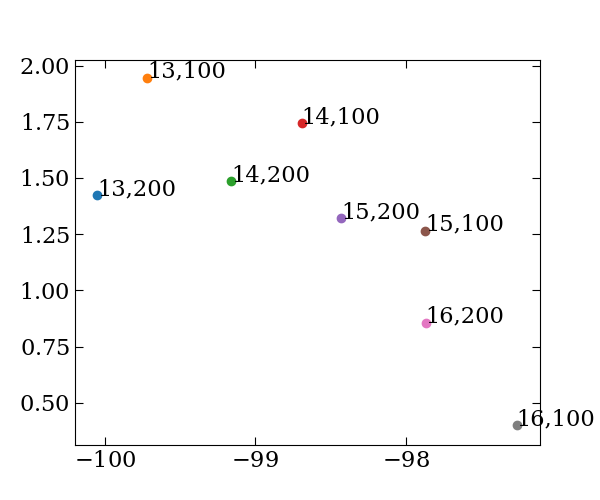

10 33 0.005 13 -1.00054e-04+1.42467e-06j 0.03505857751637955 0.0
20 33 0.01 13 -9.97217e-05+1.94660e-06j 0.021401982164853693 0.0
10 34 0.005 14 -9.91595e-05+1.48639e-06j 0.032170992739693795 0.0
20 34 0.01 14 -9.86928e-05+1.74313e-06j 0.020029958400897215 0.0
10 35 0.005 15 -9.84306e-05+1.32008e-06j 0.032595169422618524 0.0
20 35 0.01 15 -9.78720e-05+1.26625e-06j 0.020783029038916424 0.0
10 36 0.005 16 -9.78660e-05+8.57558e-07j 0.03727896895411403 0.0
20 36 0.01 16 -9.72619e-05+4.00218e-07j 0.02445149468786973 0.0
array([[-1.000543e-04+1.424673e-06j, -9.972174e-05+1.946602e-06j],
       [-9.915949e-05+1.486391e-06j, -9.869282e-05+1.743134e-06j],
       [-9.843059e-05+1.320085e-06j, -9.787196e-05+1.266252e-06j],
       [-9.786605e-05+8.575581e-07j, -9.726185e-05+4.002177e-07j]])
array([[0.035059, 0.021402],
       [0.032171, 0.02003 ],
       [0.032595, 0.020783],
       [0.037279, 0.024451]])


In [172]:
locChromas  = [13,14,15,16,17]
# locChromas  = [14,15,16]
# locChromas  = [4,5,6]
locGains = [0.005,0.0055,0.006,0.0065,0.01]
locChromas = np.arange(13,17,1) ; locGains = [0.005,0.01]

myslice = [slice(11,13+1,1),slice(33,37+1,1)]
reals = maxReals[myslice]
imags = maxImags[myslice]
etas = maxDipoleMoments[myslice]
for  i in range(3):
    arr =[reals,imags,etas][i]
#     print(arr*1e6)
    corr = [maxReals,maxImags,maxDipoleMoments][i][12,35]
    errrms = np.sqrt(np.mean((arr-corr)**2))
    diff  = (np.max(arr-corr)-np.min(arr-corr))/2
    print(['ReQ','ImQ','Eta'][i],'=%.4e +- %.4e in %.4e , %.4e'%(corr,errrms,np.min(arr),np.max(arr)))
    
#     print(arr)
plt.figure()
dQ_cohs = np.zeros((np.size(locChromas),np.size(locGains)),dtype = np.complex)
etas = np.zeros((np.size(locChromas),np.size(locGains)),dtype = np.float64)
for i,chroma in enumerate(locChromas):
    for j,gain in enumerate(locGains):
        iGain = np.argmin(np.abs(gain-dGains))
        iChroma = np.argmin(np.abs(chroma-chromas))
        
        # mask
        nSB = 5
        maskSB = np.abs(sideBands[iGain,iChroma,:])<nSB
        maskIMQ= np.imag(coherentTuneShifts[iGain,iChroma,:])>0
        mask = ((1*maskSB)*(1*maskIMQ))>0
        
        # Get values
        DQ = coherentTuneShifts[iGain,iChroma,mask]
        SB = sideBands[iGain,iChroma,mask]
        ETA = dipoleMoments[iGain,iChroma,mask]
        ind = np.argmax(ETA*np.abs(DQ)*np.imag(DQ))
        plt.scatter(DQ[ind].real*1e6,1e6*DQ[ind].imag)
        plt.annotate('%.0f,%.0f'%(chroma,1/gain),xy=(DQ[ind].real*1e6,1e6*DQ[ind].imag))
        
        print(iGain,iChroma,gain,chroma,"%.5e+%.5ej"%(DQ[ind].real,DQ[ind].imag),ETA[ind],SB[ind])
        
        dQ_cohs[i,j]=DQ[ind]
        etas[i,j]=ETA[ind]
        
np.set_printoptions(precision=6,linewidth=180,suppress=False)#formatter = {'complexfloat':'%.4e'})
print(repr(dQ_cohs))
print(repr(etas))
np.set_printoptions(precision=3,suppress=False)

gain corresponds to damping time: 1.67e+02
0.006 15.0


<IPython.core.display.Javascript object>


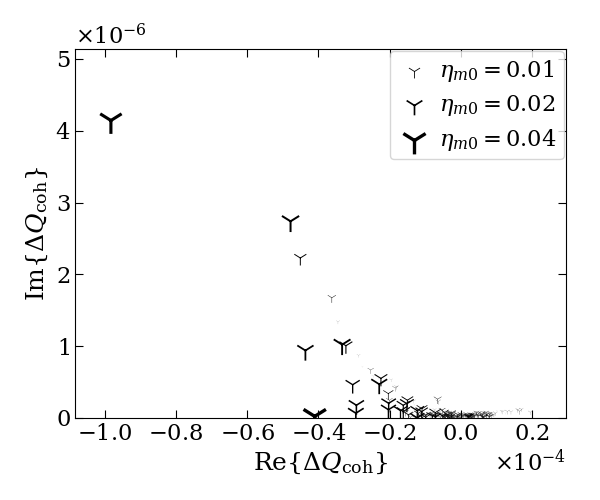

specific= -1.800e-05+2.006e-07j 0.00016213094349573607
0 -1.800330719530547e-05 2.00599473653537e-07 -8.0 0.00016213094349573607
1 8.586654587148685e-06 9.04218710599965e-08 -8.0 3.751626216196494e-05
2 -1.3105903822075773e-05 1.7031543988816257e-07 -8.0 0.00011675410107115026
3 -5.1213164573483265e-06 1.7986347459813478e-08 -8.0 0.00011901591276391172
4 4.646060433886131e-06 5.4452789506652764e-08 -8.0 4.429373464799326e-05
5 -1.3756033612175626e-05 8.156229703487592e-08 -9.0 4.072517263397327e-05
6 -1.2181371194161267e-05 1.0125298911619523e-07 -9.0 0.00010934548836236458
7 9.475944227923004e-06 4.187982454529931e-08 -9.0 8.752205093305975e-05
8 -1.0312967395430595e-05 5.85790186501388e-08 -9.0 3.179437272677119e-05
9 -9.536611157411027e-06 4.1269985340748884e-08 -9.0 3.875334867577292e-05
10 -8.514451433050096e-06 2.5080946099158657e-08 -9.0 0.00011809564783639473
11 -8.002880491220186e-06 1.2202729867179308e-08 -9.0 7.122734538600165e-05
12 7.683807510284411e-06 3.221091090888132e-

In [11]:
gain = 0.006
print('gain corresponds to damping time: %.2e'%(1/gain))
chroma = 15
iGain = np.argmin(np.abs(gain-dGains))
iChroma = np.argmin(np.abs(chroma-chromas))
print(dGains[iGain],chromas[iChroma])

sigma_dpp = 1.06538e-04
Qs = 0.0019
# factors,orders = find_DiffusionSidebandWeight(np.abs(chroma*sigma_dpp/Qs),debug=1)

# mask
nSB = 10
maskSB = np.abs(sideBands[iGain,iChroma,:])<nSB
maskIMQ= np.imag(coherentTuneShifts[iGain,iChroma,:])>0
mask = ((1*maskSB)*(1*maskIMQ))>0
        
# Get values
DQ = coherentTuneShifts[iGain,iChroma,mask]
SB = sideBands[iGain,iChroma,mask]
ETA = dipoleMoments[iGain,iChroma,mask]

fac=1

# print(np.int32(np.abs(SB)))
# x = np.array([1,2,3,4,])
# print(x[np.int32(np.abs(SB))])
DQR = np.real(DQ)
DQI = np.imag(DQ)

plt.figure(figsize=(figwidth,figheight*[0.85,1][i_layout]))

print('specific= %.3e+%.3ej'%(DQR[0]*fac,fac*DQI[0]),ETA[0])

lwfac=60 *1e0
sfac= 1e4 *1e0
if 0:
    lwfac*=1e3
    sfac*=1e3
    for i in range(nSB):
        mask = np.int32(np.abs(SB))==i
        if np.any(mask):
            plt.scatter(np.real(DQ[mask]),np.imag(DQ[mask]),
                    marker=markers[(0+i)%8],
                    linewidth=lwfac*ETA**1,s=ETA*sfac,
                    c=np.array(colors)[i%8]
                   )#color=SB)
else:
    plt.scatter(np.real(DQ),np.imag(DQ),
                    marker=markers[(3)],
                    linewidth=lwfac*ETA**1,s=ETA*sfac,
                    c='k')
            
# for i in range(nSB):
#     eta=0.025
#     plt.scatter(0,-1,marker=markers[(3+i)%8],linewidth=lwfac*eta,s=sfac*eta,c=colors[i%8],label=r'Sideband %d'%i)
for i,eta in enumerate([1e-2,2e-2,4e-2]):
    plt.scatter(0,-1,marker='1',linewidth=lwfac*eta,s=1e4*eta,c='k',
                label=r'$\eta_{m0}=$%s'%([sci_not(eta,0),short_float(eta)][1]))

# plt.errorbar(DQR[0],DQI[0],xerr = 1.04e-6,yerr=3.56e-7,fmt='none',
#             elinewidth=2,color='r',capsize=15,zorder=-1)

plt.xlim(np.min(DQR)-1e-5,np.max(DQR)+1e-5)
plt.ylim(np.min(DQI)-1e-6,np.max(DQI)+1e-6)
plt.ylim(bottom=0)
plt.legend(loc=0,ncol=1,handlelength=1.6,labelspacing=0.4)
plt.ylabel(r'$\operatorname{Im}\{ \Delta Q_\mathrm{coh}\}$')
plt.xlabel(r'$\operatorname{Re}\{ \Delta Q_\mathrm{coh}\}$')
plt.tight_layout()
plt.savefig('03_Plots/modes_nSB%d_g%s_Qp%d.eps'%(nSB,sci(gain,1),chroma))


nModes = np.size(SB)
for m in range(nModes):
    print(m,DQR[m],DQI[m],SB[m],ETA[m])

## New plots

[dGains,chromas,coherentTuneShifts,sideBands,dipoleMoments] = pkl.load(myFile)

<IPython.core.display.Javascript object>


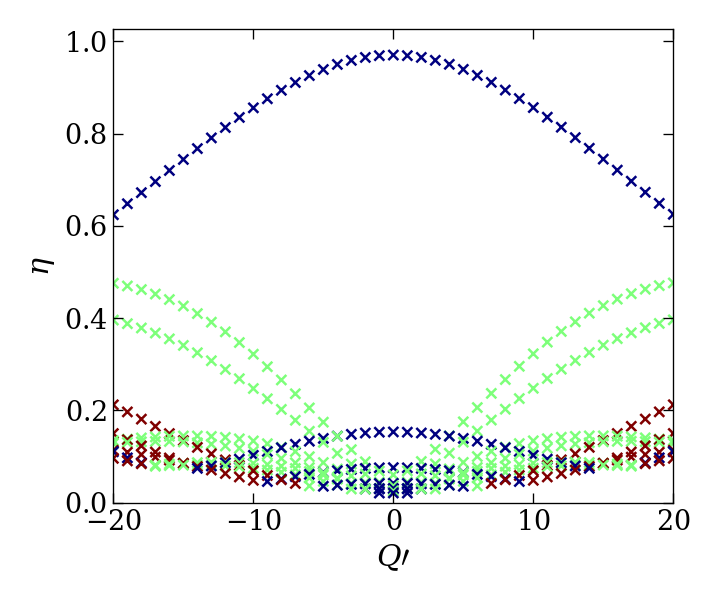

In [14]:
# Etas
plt.figure()
N=10
maxEtas = np.zeros((np.size(chromas),N))
maxSBs = np.zeros((np.size(chromas),N),dtype=np.int32)
for iChroma,chroma in enumerate(chromas):
    mask = (dipoleMoments[0,iChroma,:]).argsort()[-N:][::-1]
    maxEtas[iChroma]= dipoleMoments[0,iChroma,mask]
    maxSBs[iChroma]= sideBands[0,iChroma,mask]
#     plt.plot(chroma*np.ones(N),dipoleMoments[0,iChroma,mask].T,'x')
if 0:
    plt.plot(chromas,maxEtas,'k-',lw=2);
else:
    x= (chromas*(np.ones(N)[:,np.newaxis])).T.flatten()
    y= maxEtas.flatten()
    plt.scatter(x,y,c=np.abs(maxSBs.flatten()),marker='x',label=i,vmin=0,vmax=2)#,cmap='jet')
#     for i in range(3):
#         ind = np.abs(maxSBs).flatten()==i
#         plt.scatter(x[ind],y[ind],c=np.abs(maxSBs.flatten())[ind],marker='x',label=i,vmin=0,vmax=3)#,cmap='jet')
#     plt.legend(loc=0)
plt.xlabel(r'$Q\prime$')
plt.ylabel(r'$\eta$')
plt.ylim(bottom=0) ; plt.xlim(-20,20)
plt.tight_layout()
plt.savefig('03_Plots/dipoleMoments.eps')

In [101]:
print(figwidth,figwidthM)

6 6


<IPython.core.display.Javascript object>


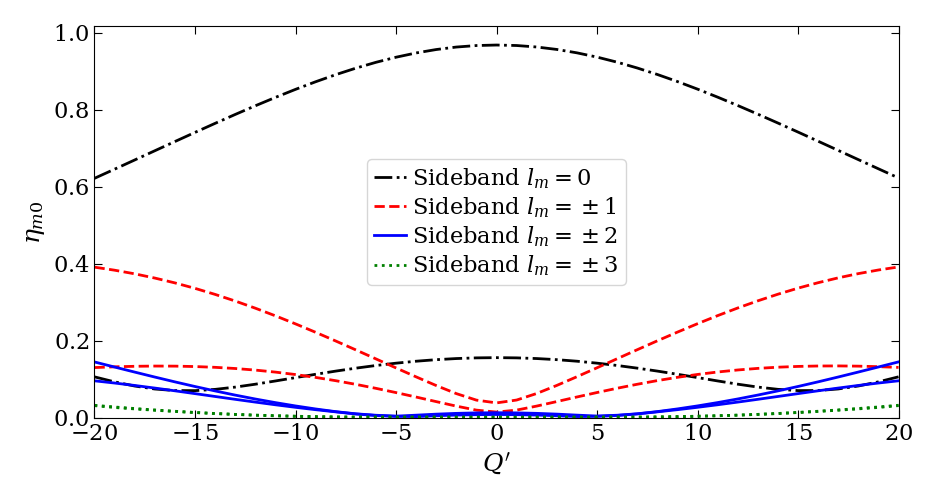

In [8]:
# Etas
igain = 0
plt.figure(figsize=(figwidthM,figheight))
N=2
maxEtas = np.zeros((np.size(chromas),N))
maxSBs = np.zeros((np.size(chromas),N),dtype=np.int32)
lss=['-.','--','-',':']
for SB in range(4):
    for iChroma,chroma in enumerate(chromas):
        mask = sideBands[igain,iChroma]==SB
        mask = (dipoleMoments[igain,iChroma,:] * mask).argsort()[-N:][::-1]
        maxEtas[iChroma]= dipoleMoments[igain,iChroma,mask]
        maxSBs[iChroma]= sideBands[igain,iChroma,mask]
    #     plt.plot(chroma*np.ones(N),dipoleMoments[0,iChroma,mask].T,'x')
    
    for i in range(N):
        plt.plot(chromas,maxEtas[:,i],lss[SB],c=['k','r','b','g'][SB],lw=2,
                 label =[r'Sideband $l_m=%s$'%(['0','\pm%d'%SB][SB>0]),None][i>0]);

        
plt.xlabel(r'$Q^\prime$')
plt.ylabel(r'$\eta_{m0}$')
plt.ylim(bottom=0) ; plt.xlim(-20,20)
plt.tight_layout()
plt.legend(loc=0,handlelength=1.4)
plt.savefig('03_Plots/dipoleMoments0.eps')

<IPython.core.display.Javascript object>


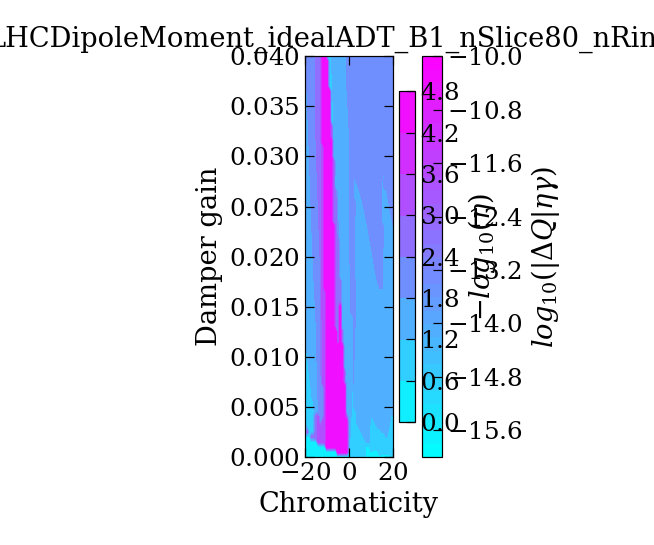

In [171]:
plt.figure(0)
levels = np.arange(-16.0,-10.0+0.001,2E-1)
maxAbs = np.abs(maxReals+1j*maxImags)
plt.contourf(chromas,dGains,1.0*np.log10(maxAbs*maxImags*maxDipoleMoments),levels=levels,cmap='cool')
plt.xlabel('Chromaticity')
plt.ylabel('Damper gain')
plt.grid()
cbar = plt.colorbar()
cbar.set_label(r'$log_{10}(|\Delta Q| \eta \gamma)$')
plt.title(studyName)
plt.tight_layout()

<IPython.core.display.Javascript object>


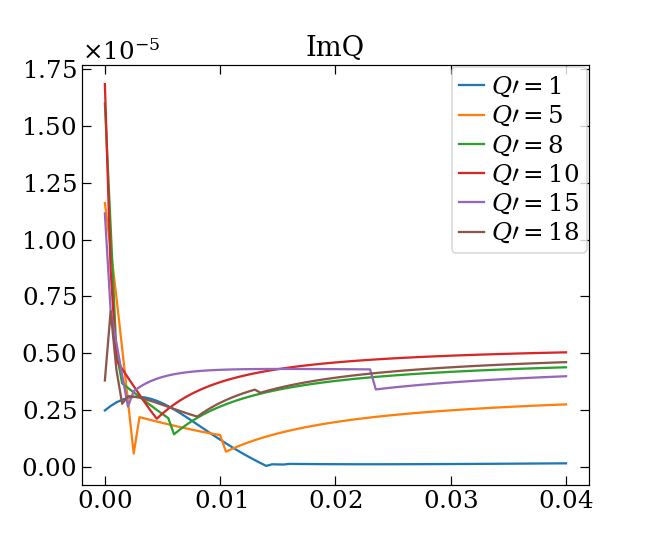

<IPython.core.display.Javascript object>


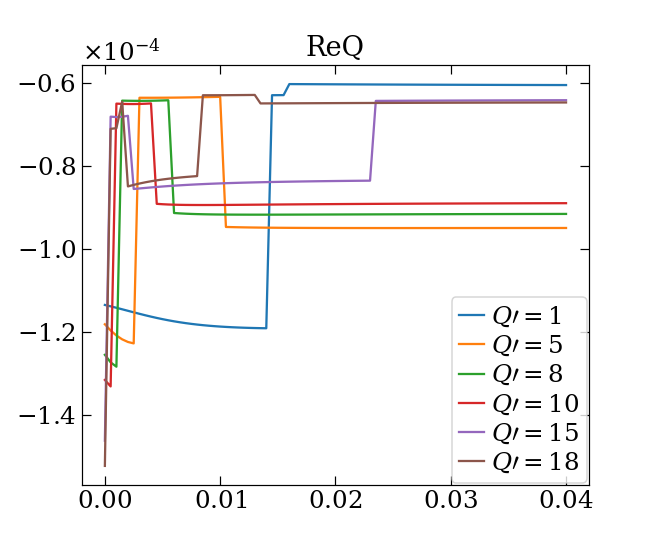

<IPython.core.display.Javascript object>


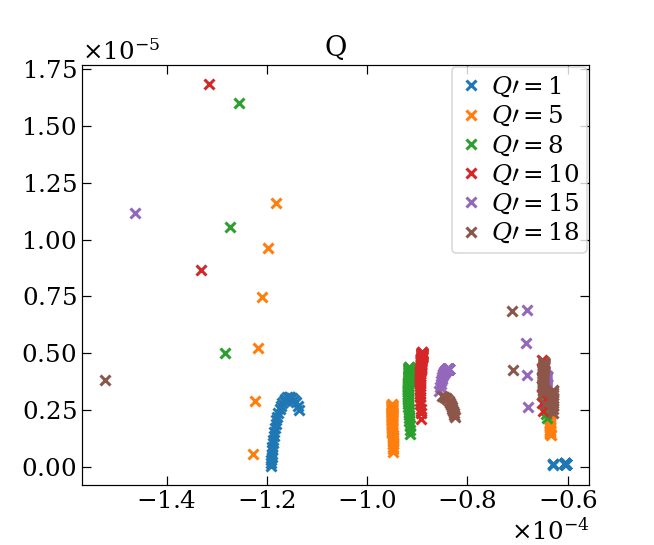

<IPython.core.display.Javascript object>


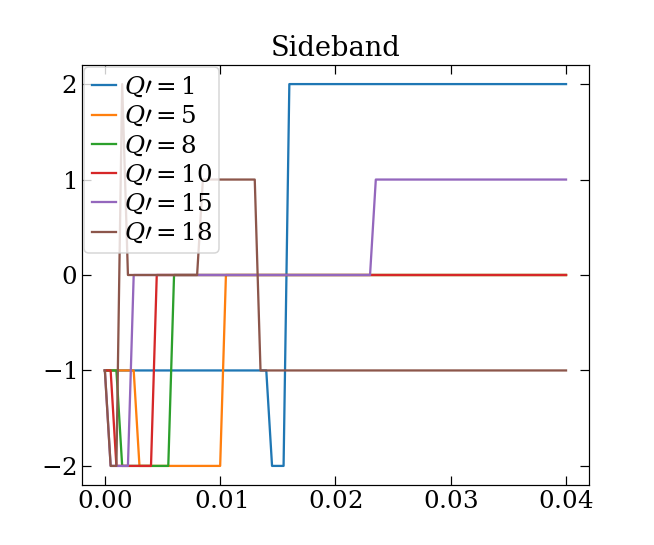

<IPython.core.display.Javascript object>


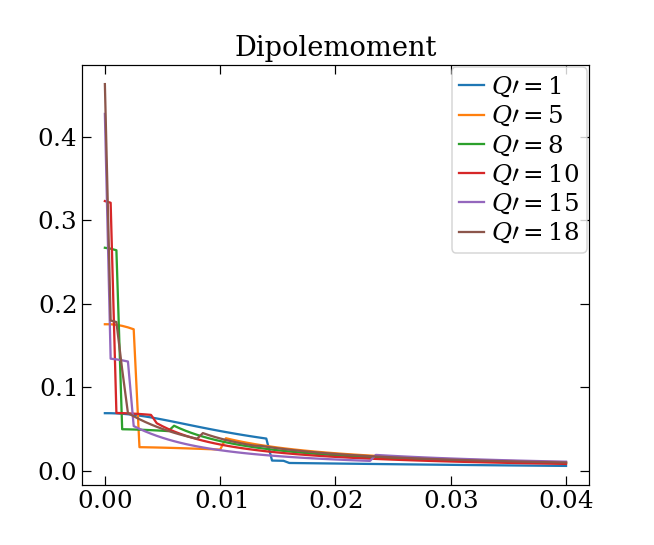

<IPython.core.display.Javascript object>


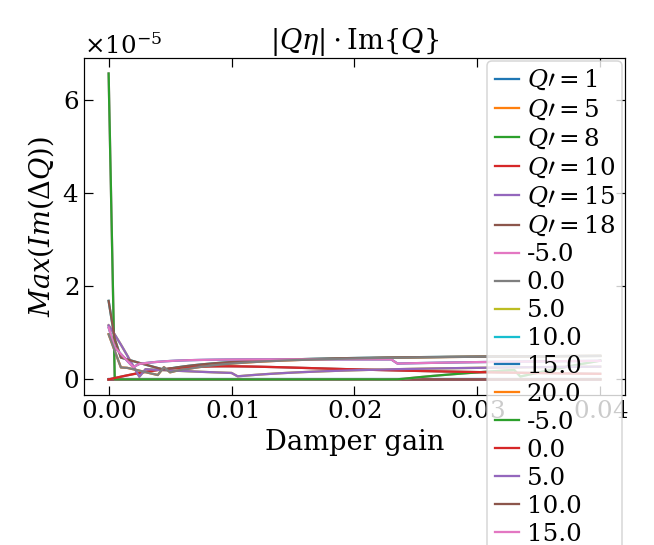

In [172]:
fig1,ax1 = plt.subplots(1)
fig2,ax2 = plt.subplots(1)
fig6,ax6 = plt.subplots(1)
fig3,ax3 = plt.subplots(1)
fig4,ax4 = plt.subplots(1)
fig5,ax5 = plt.subplots(1)


for chroma in [1,5.0,8,10.0,15.0,18]:
    indChroma  = chromas == chroma
    indGain = dGains>=-1
    
    label=r'$Q\prime=%d$'%chroma
    maxDQ = maxReals[indGain,indChroma] + 1j*maxImags[indGain,indChroma]
    maxValue=(np.abs(maxDQ)*maxDQ.imag*maxDipoleMoments[indGain,indChroma])
    
    ax1.plot(dGains,maxImags[indGain,indChroma],label=label)
    ax2.plot(dGains,maxReals[indGain,indChroma],label=label)
    ax3.plot(dGains,maxSideBand[indGain,indChroma],label=label)
    ax4.plot(dGains,maxDipoleMoments[indGain,indChroma],label=label)
    ax5.plot(dGains,maxValue,label=label)
    ax6.plot(maxDQ.real,maxDQ.imag,'x',label=label)
    
for i in range(6):
    axi = [ax1,ax2,ax3,ax4,ax5,ax6][i]
    figi = [fig1,fig2,fig3,fig4,fig5,fig6][i]
    
    title = ['ImQ','ReQ','Sideband','Dipolemoment',r'$|Q\eta|\cdot\mathrm{Im}\{Q\}$','Q'][i]
    
    axi.legend(loc=0)
    axi.set_title(title)

<IPython.core.display.Javascript object>


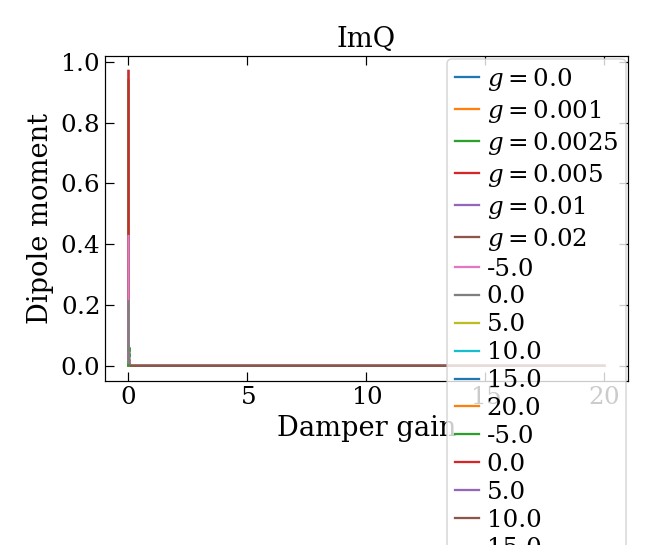

<IPython.core.display.Javascript object>


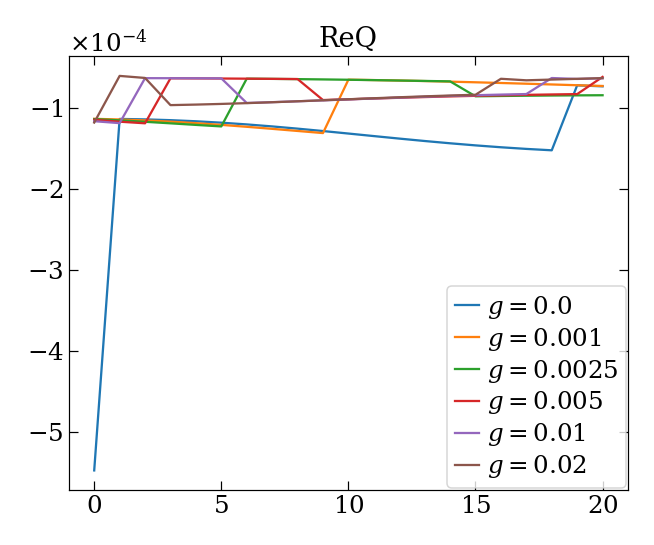

<IPython.core.display.Javascript object>


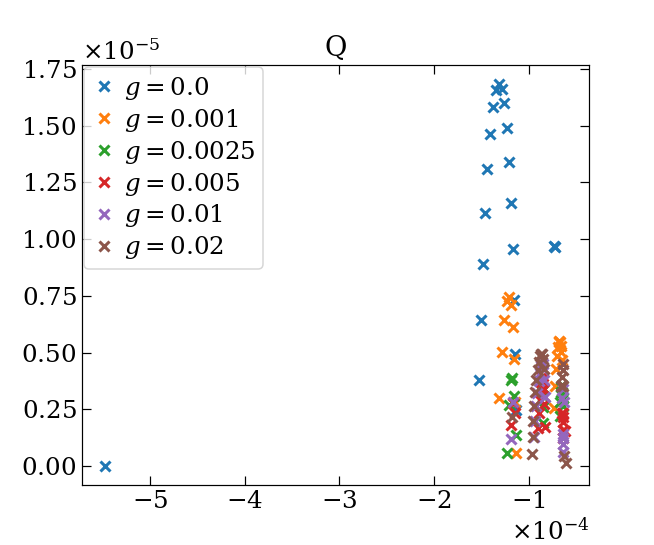

<IPython.core.display.Javascript object>


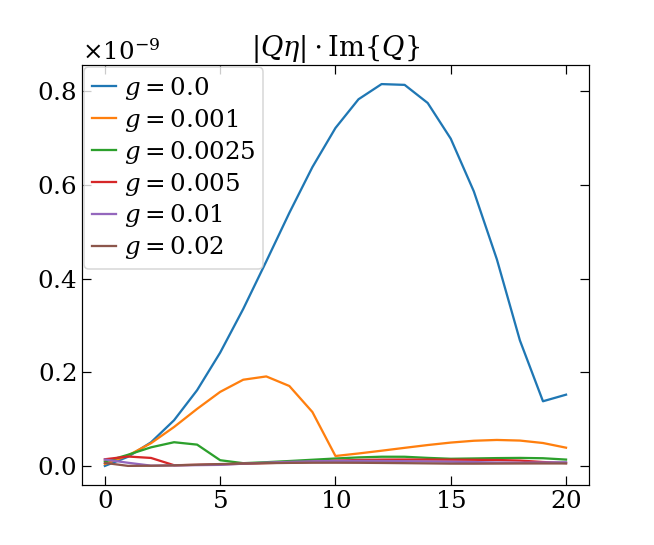

<IPython.core.display.Javascript object>


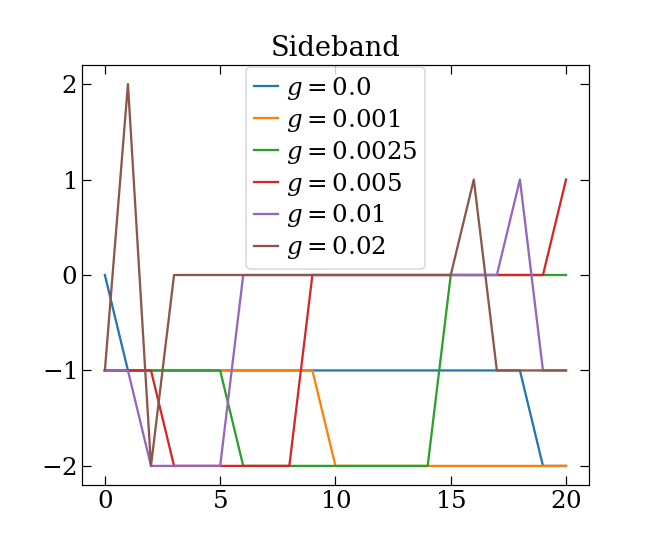

<IPython.core.display.Javascript object>


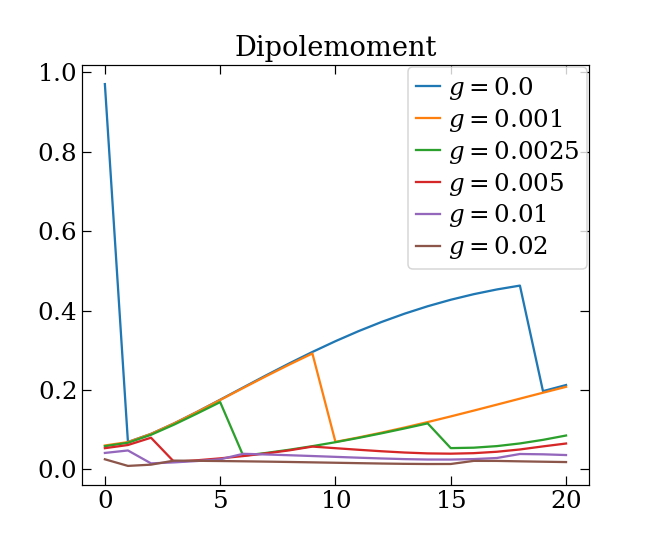

In [173]:
fig1,ax1 = plt.subplots(1)
fig2,ax2 = plt.subplots(1)
fig6,ax6 = plt.subplots(1)
fig5,ax5 = plt.subplots(1)
fig3,ax3 = plt.subplots(1)
fig4,ax4 = plt.subplots(1)



# for chroma in [0.0,5.0,10.0,15.0,20.0]:
#     mask = chromas == chroma
#     plt.figure(10)
#     plt.plot(dGains,maxImags[:,mask],label=str(chroma))
    
    
for dGain in [0.0,0.001,0.0025,0.005,0.01,0.02]:
    indChroma  = chromas > -1
    indGain = dGains == dGain
    
    label = r'$g=%s$'%str(dGain)
    maxDQ = maxReals[indGain,indChroma] + 1j*maxImags[indGain,indChroma]
    maxValue=(np.abs(maxDQ)*maxDQ.imag*maxDipoleMoments[indGain,indChroma]).T
    
    ax1.plot(chromas[indChroma],maxImags[indGain,indChroma],label=label)
    ax2.plot(chromas[indChroma],maxReals[indGain,indChroma].T,label=label)
    ax3.plot(chromas[indChroma],maxSideBand[indGain,indChroma].T,label=label)
    ax4.plot(chromas[indChroma],maxDipoleMoments[indGain,indChroma].T,label=label)
    ax5.plot(chromas[indChroma],maxValue,label=label)
    ax6.plot(maxDQ.real,maxDQ.imag,'x',label=label)
    
for i in range(6):
    axi = [ax1,ax2,ax3,ax4,ax5,ax6][i]
    figi = [fig1,fig2,fig3,fig4,fig5,fig6][i]
    
    title = ['ImQ','ReQ','Sideband','Dipolemoment',r'$|Q\eta|\cdot\mathrm{Im}\{Q\}$','Q'][i]
    
    axi.legend(loc=0)
    axi.set_title(title)

## original plots

<IPython.core.display.Javascript object>


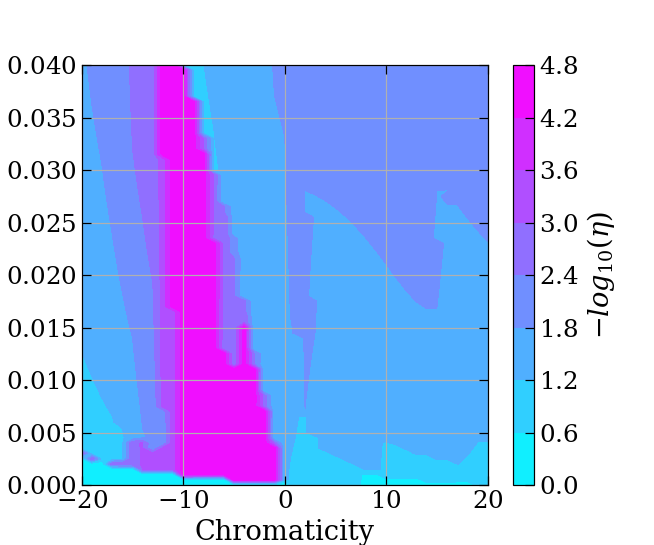

<IPython.core.display.Javascript object>


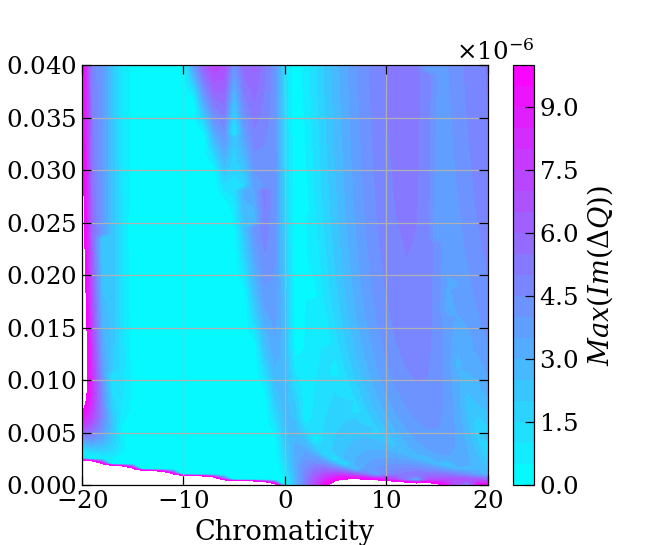

<IPython.core.display.Javascript object>


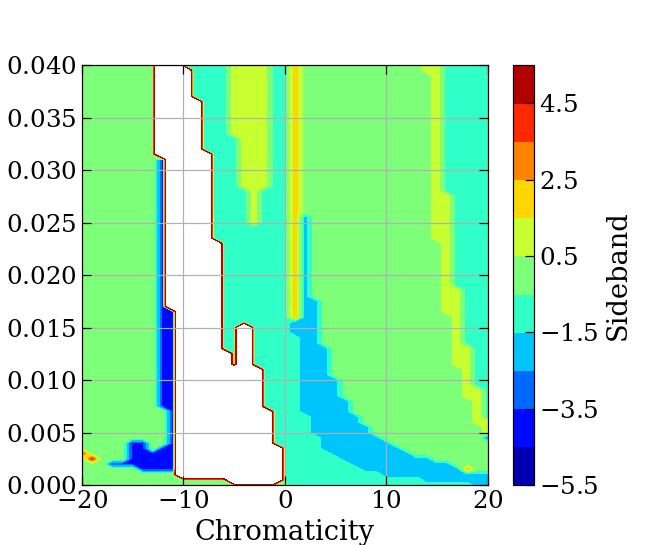

<IPython.core.display.Javascript object>


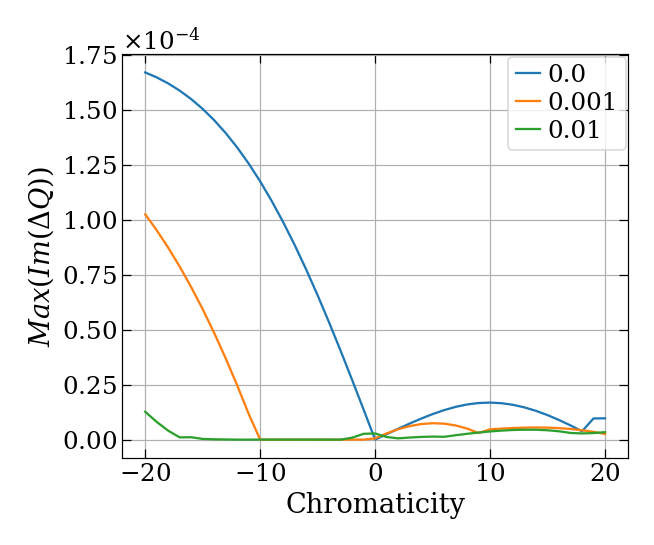

<IPython.core.display.Javascript object>


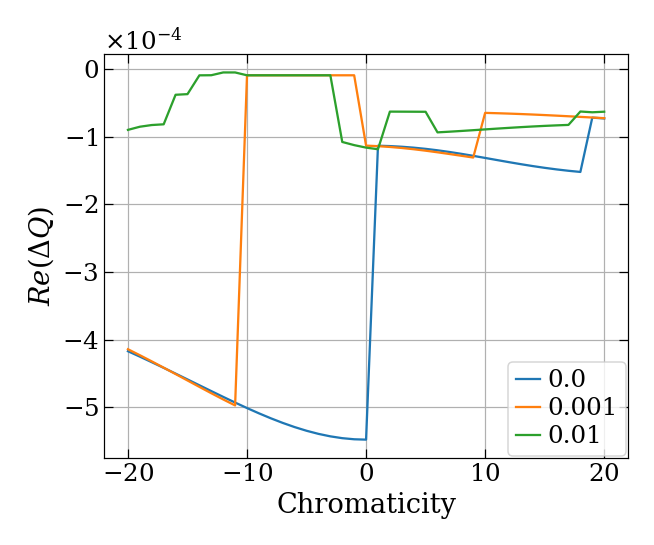

/home/sfuruset/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


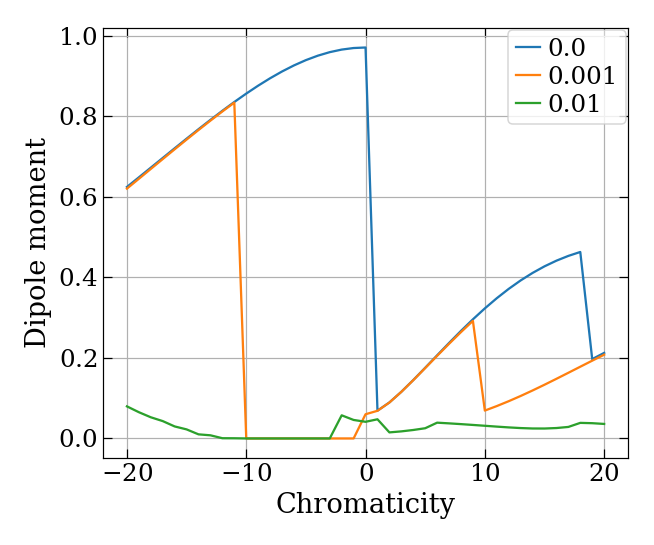

<IPython.core.display.Javascript object>


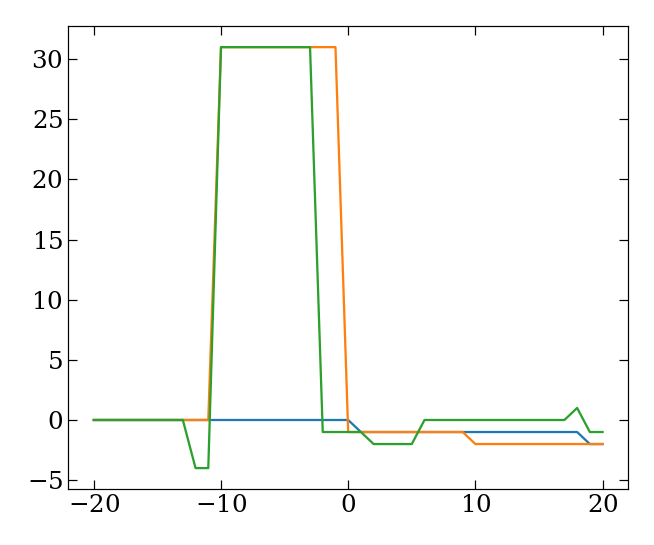

<IPython.core.display.Javascript object>


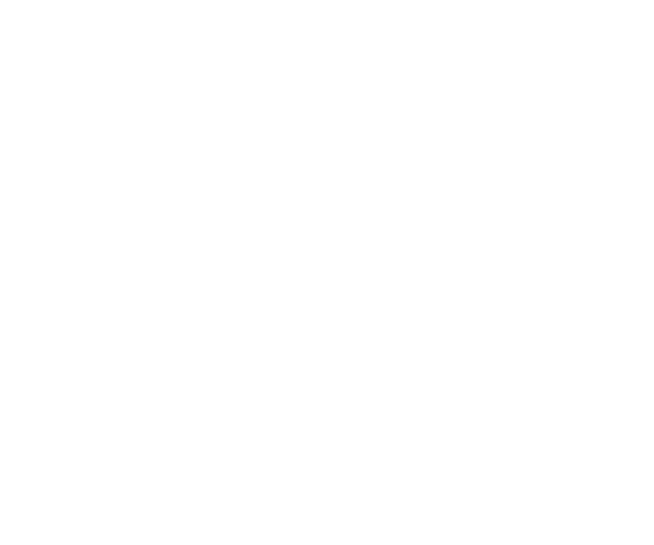

In [175]:
plt.figure(110)
levels = np.arange(0.0,1.0,2E-2)
plt.contourf(chromas,dGains,-1.0*np.log10(maxDipoleMoments),cmap='cool')
plt.xlabel('Chromaticity')
plt.ylabel('Damper gain')
plt.grid()
cbar = plt.colorbar()
cbar.set_label(r'$-log_{10}(\eta)$')

plt.figure(111)
levels = np.arange(0.0,1E-5,5E-7)
plt.contourf(chromas,dGains,maxImags,cmap='cool',levels=levels)
plt.xlabel('Chromaticity')
plt.ylabel('Damper gain')
plt.grid()
cbar = plt.colorbar()
cbar.set_label(r'$Max(Im(\Delta Q))$')

plt.figure(112)
levels = np.arange(-5.5,6.5)
plt.contourf(chromas,dGains,maxSideBand,cmap='jet',levels=levels)
plt.xlabel('Chromaticity')
plt.ylabel('Damper gain')
plt.grid()
cbar = plt.colorbar()
cbar.set_label(r'Sideband')

if True:
    for chroma in [-5.0,0.0,5.0,10.0,15.0,20.0]:
        mask = chromas == chroma
        plt.figure(10)
        plt.plot(dGains,maxImags[:,mask],label=str(chroma))
        plt.figure(11)
        plt.plot(dGains,maxDipoleMoments[:,mask],label=str(chroma))
    plt.figure(10)
    plt.xlabel('Damper gain')
    plt.ylabel(r'$Max(Im(\Delta Q))$')
    plt.grid()
    plt.legend()
    plt.figure(11)
    plt.xlabel('Damper gain')
    plt.ylabel(r'Dipole moment')
    plt.grid()
    plt.legend()

    for dGain in [0.0,0.001,0.01]:
        mask = dGains == dGain
        plt.figure(20)
        plt.plot(chromas,np.transpose(maxImags[mask,:]),label=str(dGain))
        plt.figure(21)
        plt.plot(chromas,np.transpose(maxReals[mask,:]),label=str(dGain))
        plt.figure(22)
        plt.plot(chromas,np.transpose(maxDipoleMoments[mask,:]),label=str(dGain))
        plt.figure(23)
        plt.plot(chromas,np.transpose(maxSideBand[mask,:]),label=str(dGain))
    plt.figure(20)
    plt.xlabel('Chromaticity')
    plt.ylabel(r'$Max(Im(\Delta Q))$')
    plt.grid()
    plt.legend()
    plt.figure(21)
    plt.xlabel('Chromaticity')
    plt.ylabel(r'$Re(\Delta Q)$')
    plt.grid()
    plt.legend()
    plt.figure(22)
    plt.xlabel('Chromaticity')
    plt.ylabel(r'Dipole moment')
    plt.grid()
    plt.legend()

    for fignr in [0,1,2,10,11,12,20,21,22,23]:
        plt.figure(fignr)
        plt.tight_layout()




# Sacherer

In [170]:
Qx = 0.31
wx = 2*np.pi*Qx
sigma_z = 1
N=100

mode=1
z = np.linspace(-1,1,N)*sigma_z #* [1,1,6][mode]

l=0
X=1

<IPython.core.display.Javascript object>


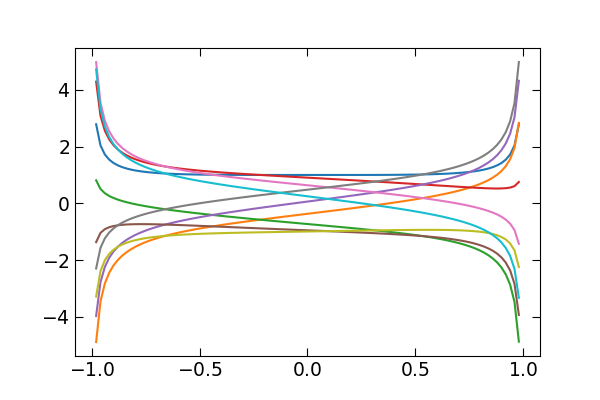

/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [175]:
# def density(z,sigma_z,mode):
#     if mode==0:
#         return 1
#     elif mode==1:
#         return 1/np.sqrt(sigma_z**2-z**2)
#     elif mode==2:
#         return 1/np.sqrt(2*np.pi)/sigma_z * np.exp(-z**2/sigma_z**2*0.5)
    
def dipole_z(z,X,l,t):
    return 1/np.sqrt(sigma_z**2-z**2) * np.cos(l*np.arccos(z/sigma_z)) * np.cos(wx*t - X*z/sigma_z)
#     return density(z,sigma_z,mode) * np.cos(l*np.arccos(z/sigma_z)) * np.cos(wx*t - X*z/sigma_z)

Nt=10
dips = np.zeros(Nt)


plt.figure()
for t in range(Nt):
    dip = dipole_z(z,X,l,t)
    plt.plot(z,dip)
    

    
    dips[t] = integrate.quad(dipole_z,-sigma_z,sigma_z,args=(X,l,t,))[0]

# print(1/np.mean(dips))

In [197]:
Nt=30
Nx=15
Nl=4


ls=np.arange(Nl)
Xs = np.linspace(0,2,Nx)
dips = np.zeros((Nl,Nx,Nt))

for i,l in enumerate(ls):
    for j,X in enumerate(Xs):
        for t in range(Nt):
            dips[i,j,t]= abs(integrate.quad(dipole_z,-sigma_z,sigma_z,args=(X,l,t,))[0])
        

/home/sfuruset/miniconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


<IPython.core.display.Javascript object>


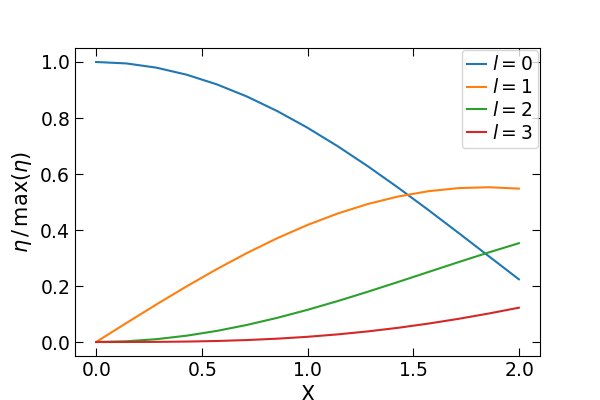

Text(0, 0.5, '$\\eta\\,/\\,\\mathrm{max}(\\eta)$')

In [200]:
plt.figure()
for i,l in enumerate(ls):
    plt.plot(Xs,np.mean(dips[i],axis=1)/np.mean(dips[0,0]),label=r'$l=%d$'%l)
plt.legend(loc=0)
plt.xlabel('X')
plt.ylabel(r'$\eta\,/\,\mathrm{max}(\eta)$')